# Identifying YSOs with a neural network

In [19]:
#ML imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

#System/general imports
import math
import imf
import random
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
import time

#Data imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
# import tables

#Astro imports
from astropy.io import fits
from astropy.table import Table
from isochrones import parsec
from isochrones.mist import MIST_Isochrone
from isochrones.parsec import Parsec_Isochrone
mist = Parsec_Isochrone()

def getmagerror(flux,eflux):
    return (-2.5*np.log10(flux-eflux)+2.5*np.log10(flux+eflux))/2

import astropy.units as u
# device = torch.device('cuda:0')

# import pymultinest

In [2]:
clusterx ,clustery =pickle.load(open('ysotrainf1ms.pickle', 'rb'))
clusterx1,clustery1=pickle.load(open('ysotrainf2ms.pickle', 'rb'))
clusterx2,clustery2=pickle.load(open('ysotrainf3ms.pickle', 'rb'))

print(clustery.size())
print(clustery1.size())
print(clustery2.size())

# print(-2.5*np.log10(10**(-mist.mag['G'](mass, 8, feh, distance, AV)/2.5)))
# print(-2.5*np.log10(10**(-mist.mag['G'](mass, 8.3, feh, distance, AV)/2.5)))
# print(-2.5*np.log10(10**(-mist.mag['G'](mass, 7.5, feh, distance, AV)/2.5)))

torch.Size([88089, 6])
torch.Size([87564, 6])
torch.Size([88112, 6])


The following code is used to generate the clusters

Here's our neural network, taking twelve inputs

In [3]:
class Net(nn.Module):
    def __init__(self, input_shape = (1,12), outputsize=6):
        super(Net,self).__init__()
        self.conv1 = nn.Conv1d(1,8,3, padding=1)
        self.conv2 = nn.Conv1d(8,16,3, padding = 1)
        self.conv3 = nn.Conv1d(16,32,3,padding =1)
        n_size =self._get_conv_output(input_shape)
        self.fc1 = nn.Linear(n_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, outputsize)
    
    #Generate input sample and forward to get shape
    def _get_conv_output(self, shape):
        bs = 1
        input = torch.rand(bs, *shape)
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size
    
    def _forward_features(self, x):
        x = F.max_pool1d(F.relu(self.conv2(F.relu(self.conv1(x)))),2)
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
#Initialize model
BAD_LOSS= 100000000
model = Net()#initialize our network

In [4]:
device = torch.device("cuda")
# model=model.to(device)
# clusterx = clusterx.to(device)
# clustery = clustery.to(device)
# clusterx1 = clusterx1.to(device)
# clustery1 = clustery1.to(device)
# clusterx2 = clusterx2.to(device)
# clustery2 = clustery2.to(device)

In [4]:
inputs = clusterx
target = clustery

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-5, momentum = .9)

best_loss = BAD_LOSS
running_dev_loss = 0
badcount = 0
t = time.time()

a = torch.rand(23500, 1, 12)
print(clusterx.size())
print(a.size())
print(model(clusterx))

torch.Size([88089, 1, 12])
torch.Size([23500, 1, 12])
tensor([[ 0.0723, -0.0035, -0.0272, -0.0087,  0.0547, -0.0525],
        [ 0.0689, -0.0023, -0.0245, -0.0089,  0.0556, -0.0529],
        [ 0.0719, -0.0041, -0.0292, -0.0087,  0.0542, -0.0512],
        ...,
        [ 0.0706, -0.0028, -0.0259, -0.0086,  0.0558, -0.0528],
        [ 0.0722, -0.0049, -0.0296, -0.0092,  0.0541, -0.0513],
        [ 0.0713, -0.0043, -0.0277, -0.0089,  0.0548, -0.0513]],
       grad_fn=<AddmmBackward>)


The following would be used to start the process, but we want to resume instead

In [6]:
def resume(savept, n=0):
    model = Net()
    model.load_state_dict(torch.load(savept))
    model=model.to(device)    
    
    clusterx.requires_grad=True
    clustery.requires_grad=True
    optimizer = torch.optim.SGD(model.parameters(), lr = 1e-5, momentum = .9)
    start_time = time.time()
    ran = range(85000)
    
    for epoch in range(1000):
        model.train()
        t = time.time()
        k=random.sample(ran, len(ran))
        running_loss = 0
        for i in range(850):
            inputs = clusterx[k[i*100:(i+1)*100]]
            target = clustery[k[i*100:(i+1)*100]]
            optimizer.zero_grad()#zero parameter gradients

            #forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            getloss = loss.item()
            running_loss = getloss + running_loss

        n=n+1
        if n % 1 == 0:
            model.eval()
            optimizer.zero_grad()
            with torch.no_grad():
                dev_outputs = model.forward(clusterx)
                dev_loss = criterion(dev_outputs, clustery)
            print( (n, time.time()-t, running_loss, dev_loss.item()))
        if n % 10 == 0:
            torch.save(model.state_dict(), 'intermediatemodel.pt')
            pickle.dump(n, open('ncount.pickle','wb'))

In [29]:
mwTab = fits.open('.\\data\\mwclustering+gaia.fits')
mwTab = Table(mwTab[1].data)
mwTab

SOURCE_ID,LABELS,PROB,RA,DEC,PARALLAX,VLSRRA,VLSRDEC,BP_RP,ABSG,L,L1,B,AGE,av,PHOT_G_MEAN_FLUX,PHOT_G_MEAN_FLUX_ERROR,PHOT_G_MEAN_MAG,PHOT_BP_MEAN_FLUX,PHOT_BP_MEAN_FLUX_ERROR,PHOT_BP_MEAN_MAG,PHOT_RP_MEAN_FLUX,PHOT_RP_MEAN_FLUX_ERROR,PHOT_RP_MEAN_MAG,PARALLAX_ERROR,VLSRL,VLSRB,SLABEL,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,VLSRV,J_M,J_MSIGCOM,H_M,H_MSIGCOM,KS_M,KS_MSIGCOM,W1MPRO,W1MPRO_ERROR,W2MPRO,W2MPRO_ERROR,W3MPRO,W3MPRO_ERROR,W4MPRO,W4MPRO_ERROR,NAME,PLOTNAME,ID,radius_val,lum_val
int64,int32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float32,float32,float64,float64,float32,float64,float64,float32,float64,float64,float32,float64,float32,float32,int32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,str17,str23,int32,float32,float32
38329666836450304,0,0.3963411,59.560418133520294,12.627972113742858,21.946148,93.95774,34.56727,nan,nan,177.7996010614763,177.7996010614763,-29.72958444322383,8.8,0.25,17017.021516935332,7.822960373723365,15.111156,2162.3614057960326,10.214138597784247,17.014067,24263.8287519821,40.45028206947003,13.799521,0.10251905075692777,37.1957,92.94855,-1,nan,nan,nan,11.845,0.022,11.256,0.022,10.987,0.018,10.802,0.023,10.607,0.02,10.372,0.088,8.804,nan,Hyades,Hyades (1007),1007,nan,nan
39305036729495936,0,0.4818468,60.92599668041765,14.99122358385888,24.05271,104.09811,30.17945,-0.12748432,11.94467,176.80337939735148,176.80337939735148,-27.16517080974734,8.8,0.25,18188.896363827098,7.247010899969845,15.03885,14024.004346464608,35.33660191394612,14.984208,7245.87975348997,12.32284762813272,15.111692,0.054050574868840816,47.505375,97.41896,-1,nan,nan,nan,15.421,0.053,15.704,0.136,15.329,0.19,15.305,0.041,15.131,0.094,11.816,0.295,8.977,0.491,Hyades,Hyades (1007),1007,nan,nan
39363070327534336,1920,0.14193504,60.156419382944634,15.143127015504739,6.1988597,5.3563347,-21.953695,2.8042326,10.203449,176.11470887230166,176.11470887230166,-27.613960245439603,8.4,0.2,6006.0724128456395,4.971771061106222,16.24189,1026.6453594984653,5.60883967064932,17.822838,7894.522258405675,12.662964001849296,15.018605,0.09008682251985371,19.770664,-10.944219,-1,nan,nan,nan,13.247,0.023,12.633,0.022,12.382,0.027,12.233,0.023,12.064,0.023,11.74,nan,8.595,nan,,Theia 513,513,nan,nan
40137573190305792,1,1.0,59.81629664868571,15.504794535097309,2.7395082,29.106339,-11.58897,1.2270145,5.6313086,175.5636917283863,175.5636917283863,-27.610602956572745,9.853588,0.24057159,79098.45060645344,13.97994004292804,13.4429455,35162.09633277509,53.66261374018607,13.986201,63254.77872589412,37.77591245844094,12.759187,0.028381431748015683,28.331543,13.371867,208,nan,nan,nan,11.876,0.022,11.484,0.023,11.326,0.02,11.305,0.023,11.332,0.021,11.345,0.193,8.456,nan,,Theia 1635,1635,0.96149796,0.47261554
40470720915966208,0,0.45782667,58.722347353567244,16.315525293983768,22.731167,96.4998,29.577772,nan,nan,174.08230568310094,174.08230568310094,-27.82098240099255,8.8,0.25,123696.04226408669,116.57542382134397,12.957477,20383.962852859724,81.25016941759372,14.578167,163653.31978917526,325.7859807438183,11.727108,0.15432958914230888,45.77411,89.95437,-1,nan,nan,nan,9.96,0.024,9.367,0.022,9.056,0.021,8.938,0.023,8.775,0.019,8.672,0.03,8.733,0.487,Hyades,Hyades (1007),1007,nan,nan
43538293935879680,0,0.4290749,58.77774769456368,16.99837362867533,24.399475,107.34322,32.350323,1.0694065,5.6717095,173.56853269549248,173.56853269549248,-27.309449147689907,8.8,0.25,6045376.522912375,4078.565961106053,8.734807,2856064.3078265367,6835.483373365894,9.211968,4443682.989685498,7798.5646368042135,8.142562,0.041648141244786614,51.701305,99.47907,-1,36.40345701277087,0.1750346509308346,24.49468665862789,7.413,0.02,7.038,0.027,6.91,0.021,6.886,0.068,6.92,0.02,6.92,0.017,6.909,0.088,Hyades,Hyades (1007),1007,0.8491782,0.43505016
43615122310787840,0,0.4753932,58.29250122010277,17.326960072874126,23.089685,104.886,24.457527,0.47562885,2.6853738,1

In [41]:
size = len(mwTab)
clx = np.recarray(size, 
                 dtype= [('g', float), ('bp', float), ('rp', float), ('j', float),
                         ('h', float), ('k', float), ('w1', float), ('w2', float),
                         ('w3', float), ('parallax', float), ('radius', float),('logl', float)])

clx.g = mwTab['PHOT_G_MEAN_MAG']
clx.bp = mwTab['PHOT_BP_MEAN_MAG']
clx.rp = mwTab['PHOT_RP_MEAN_MAG']
clx.j = mwTab['J_M']
clx.h = mwTab['H_M']
clx.k = mwTab['KS_M']
clx.w1 = mwTab['W1MPRO']
clx.w2 = mwTab['W2MPRO']
clx.w3 = mwTab['W3MPRO']
clx.parallax = mwTab['PARALLAX']
clx.radius = (mwTab['radius_val'])
clx.logl = np.log10(mwTab['lum_val'])
# clx.logl = np.log10(mwTab['lum_val']/u.astrophys.solLum).value

clx['g'][np.where(clx.g>19)[0]]=float('NaN')
clx['bp'][np.where(clx.bp>20.5)[0]]=float('NaN')
clx['rp'][np.where(clx.rp>17.5)[0]]=float('NaN')
clx['j'][np.where(clx.j>17)[0]]=float('NaN')
clx['h'][np.where(clx.h>16)[0]]=float('NaN')
clx['k'][np.where(clx.k>16)[0]]=float('NaN')
clx['w1'][np.where(clx.w1>16)[0]]=float('NaN')
clx['w2'][np.where(clx.w2>16)[0]]=float('NaN')
clx['w3'][np.where(clx.w3>13.5)[0]]=float('NaN')
clx=clx[np.where(np.isfinite(clx.g)==True)[0]]
clx['bp'][np.where(np.isfinite(clx.bp)==False)[0]]=21
clx['rp'][np.where(np.isfinite(clx.rp)==False)[0]]=18
clx['j'][np.where(np.isfinite(clx.j)==False)[0]]=17.5
clx['h'][np.where(np.isfinite(clx.h)==False)[0]]=16.5
clx['k'][np.where(np.isfinite(clx.k)==False)[0]]=16.5
clx['w1'][np.where(np.isfinite(clx.w1)==False)[0]]=16.5
clx['w2'][np.where(np.isfinite(clx.w2)==False)[0]]=16.5
clx['w3'][np.where(np.isfinite(clx.w3)==False)[0]]=14
clx['radius'][np.where(clx.radius<0.5)[0]]=0.5
clx['logl'][np.where(clx.logl<-1.54)[0]]=-1.54
k=np.where(clx.g-5*(np.log10(1000/clx.parallax)-1)>10)[0]
clx['radius'][k]=0.5
clx['logl'][k]=-1.54
size=len(clx)

dataX = torch.Tensor(size,1,12)
dataY = torch.Tensor(size,6)

for a in range(size):
    dataX[a][0][0]=0.5
    dataX[a][0][1]=0.5
    dataX[a][0][2]=0.5
    dataX[a][0][3]=0.5
    dataX[a][0][4]=0.5
    dataX[a][0][5]=0.5
    dataX[a][0][6]=0.5
    dataX[a][0][7]=0.5
    dataX[a][0][8]=0.5
    dataX[a][0][9]=0.5
    
    dataX[a][0][0]=clx['g'][a].astype(float)/21-0.5
    dataX[a][0][1]=clx['bp'][a].astype(float)/21-0.5
    dataX[a][0][2]=clx['rp'][a].astype(float)/18-0.5
    dataX[a][0][3]=clx['j'][a].astype(float)/17.5-.5
    dataX[a][0][4]=clx['h'][a].astype(float)/16.5-.5
    dataX[a][0][5]=clx['k'][a].astype(float)/16.5-.5
    dataX[a][0][6]=clx['w1'][a].astype(float)/16.5-.5
    dataX[a][0][7]=clx['w2'][a].astype(float)/16.5-.5
    dataX[a][0][8]=clx['w3'][a].astype(float)/14-.5
    dataX[a][0][9]=clx['parallax'][a].astype(float)/20-.5
    dataX[a][0][10]=(clx['radius'][a].astype(float)-.2)/5-.5
    dataX[a][0][11]=clx['logl'][a].astype(float)/4

In [31]:
device = torch.device('cpu')
model = Net(input_shape=(1,12), outputsize = 6)
k = torch.load('intermediatemodel.pt')
model = model.to(device)

dataX = dataX.to(device)
dataY = dataY.to(device)

In [32]:
model.eval()
result = model(dataX)

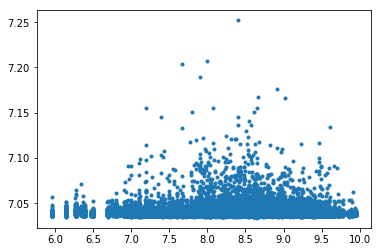

In [40]:
MWTab = mwTab[np.where(np.isfinite(clx.g)==True)[0]]
nnOuts = pd.DataFrame(result.detach().numpy(),columns=['age','av','mass','teff','logg','feh'])
plt.plot((MWTab['AGE']),(nnOuts.age+.5)*2 + 6,'.')

In [ ]:
d=fits.open('.\\Data\\mwclustering+gaiaVals.fits')
data1=d[1].data
d.close()
data1['phot_bp_mean_mag'][np.where(np.isnan(data1['phot_bp_mean_mag']))[0]]=21
data1['phot_rp_mean_mag'][np.where(np.isnan(data1['phot_rp_mean_mag']))[0]]=18
data1['j_m'][np.where(np.isnan(data1['j_m']))[0]]=17.5
data1['h_m'][np.where(np.isnan(data1['h_m']))[0]]=16.5
data1['ks_m'][np.where(np.isnan(data1['ks_m']))[0]]=16.5
data1['w1mpro'][np.where(np.isnan(data1['w1mpro']))[0]]=16.5
data1['w2mpro'][np.where(np.isnan(data1['w2mpro']))[0]]=16.5
data1['w3mpro'][np.where(np.isnan(data1['w3mpro']))[0]]=14
data1['radius_val'][np.where(np.isnan(data1['radius_val']))[0]]=0.5
data1['lum_val'][np.where(np.isnan(data1['lum_val']))[0]]=10**(-1.54)
k=np.where(data1['phot_g_mean_mag']-5*(np.log10(1000/data1['parallax']-1))>10)[0]
data1['radius_val'][k]=0.5
data1['lum_val'][k]=10**(-1.54)


datax=torch.Tensor (len(data1['phot_g_mean_mag']), 1,12)

for a in range(len(data1['phot_g_mean_mag'])):
    
    datax[a][0][0]=0.5
    datax[a][0][1]=0.5
    datax[a][0][2]=0.5
    datax[a][0][3]=0.5
    datax[a][0][4]=0.5
    datax[a][0][5]=0.5
    datax[a][0][6]=0.5
    datax[a][0][7]=0.5
    datax[a][0][8]=0.5
    datax[a][0][9]=0.5
    
    datax[a][0][0]=data1['phot_g_mean_mag'][a]/21-0.5
    datax[a][0][1]=data1['phot_bp_mean_mag'][a]/21-0.5
    datax[a][0][2]=data1['phot_rp_mean_mag'][a]/18-0.5
    datax[a][0][3]=data1['j_m'][a]/17.5-0.5
    datax[a][0][4]=data1['h_m'][a]/16.5-0.5
    datax[a][0][5]=data1['ks_m'][a]/16.5-0.5
    datax[a][0][6]=data1['w1mpro'][a]/16.5-0.5
    datax[a][0][7]=data1['w2mpro'][a]/16.5-0.5
    datax[a][0][8]=data1['w3mpro'][a]/14-0.5
    datax[a][0][9]=data1['parallax'][a]/20-0.5
    datax[a][0][10]=(data1['radius_val'][a]-0.2)/5-0.5
    datax[a][0][11]=np.log10(data1['lum_val'][a])/4

In [ ]:
device = torch.device('cpu')
model = Net(input_shape=(1,12), outputsize = 6)
k = torch.load('intermediatemodel.pt')
model = model.to(device)

dataX = dataX.to(device)
dataY = dataY.to(device)

model.eval()
a = model(datax)
result = pd.DataFrame(a.detach().numpy(),columns = ['age', 'av','mass','teff','logg', 'feh'])

In [ ]:
plt.plot((result.mass+.5)*3, (result.age+.5)*2+6, '.')